# Implement Transformer from Scratch

In this coding homework, we will:

- Implement a simple transformer model from scratch to enhance your understanding of how it works.
- Create a hand-designed transformer model capable of solving a basic problem. This will help you comprehend the various operations that transformers can perform.
- Analyze the attention patterns of a trained network to gain insights into how learned models often utilize features that differ greatly from those employed by humans.

In [1]:
import time
import json
import inspect
import numpy as np
import torch
import torch.nn as nn
import math
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5]  # Adjust this to make plots bigger or smaller

%load_ext autoreload
%autoreload 2

def _set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

TO_SAVE = {"time": time.time()}

## Implement a Simple Transformer

Below, you'll find a simple transformer implementation in Numpy that we have provided for you. It's important to note that this implementation is different from a Transformer in real applications. The differences include:

- Only a single layer with a single head is in the network.
- There are no residual connections.
- There is no normalization or dropout.
- We concatenate the positional encoding rather than adding it to the inputs.
- There are no activation functions or MLP layers.
- It does not support attention masking.
- The input is a single sequence instead of a batch. So there is no need to implement padding.

To ensure that you understand the transformer model fully, your task is to **implement a PyTorch equivalent model**. You don't need to include the printing and plotting code found in the Numpy version. **You should implement a vectorized version of the attention operation**, meaning that you should calculate all attention scores at once, rather than looping over keys. Once you have completed your implementation, make sure it passes the tests included in the cell below.

In [2]:
#@title Helper Functions

def rescale_and_plot(arr, title='', ax=None, x_lab=None, y_lab=None):
    """Rescale input array to be between 0 and 1, then plot it"""
    arr = (arr - arr.min())
    if arr.max() > 0:
        arr = arr / arr.max()
    ax.imshow(arr, cmap="Reds")
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if x_lab is not None:
        ax.set_xlabel(x_lab)
    if y_lab is not None:
        ax.set_ylabel(y_lab)


def train_loop(make_batch, input_dim, qk_dim, v_dim, pos_dim=None, max_seq_len=None, remove_cls=False, num_epochs=10001, lr=3e-2):
    transformer = PytorchTransformer(input_dim, qk_dim, v_dim, pos_dim, max_seq_len)
    optimizer = torch.optim.SGD(transformer.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for i in range(num_epochs):
        seq, target = make_batch()
        optimizer.zero_grad()
        out = transformer(seq)
        # If remove_cls is True, remove the first item of the sequence (the CLS token)
        if remove_cls:
            out = out[1:]
        loss = loss_fn(out, target)
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(f'Step {i}: loss {loss.item()}')
    return transformer, loss.item()

def compare_transformers(hand_transformer, learned_transformer, seq):
    # Print the learned matrices
    # Rescale each weight matrix to be between 0 and 1, then plot them
    print('=' * 40, ' Hand Designed ', '=' * 40)
    out_hand = hand_transformer.forward(seq, verbose=False, plot=True)

    # Copy weights from the learned transformer to the hand transformer
    # so we can run the hand transformer's forward pass, with the plotting code
    py_Km = learned_transformer.Km.weight.T.detach().numpy()
    py_Qm = learned_transformer.Qm.weight.T.detach().numpy()
    py_Vm = learned_transformer.Vm.weight.T.detach().numpy()
    # positional encodings, if they exist
    if learned_transformer.pos is not None:
        py_pos = learned_transformer.pos.weight.detach().numpy()
    else:
        py_pos = None

    print('=' * 40, '   Learned   ', '=' * 40)
    np_learned_transformer = NumpyTransformer(py_Km, py_Qm, py_Vm, py_pos)
    out_learned = np_learned_transformer.forward(seq, verbose=False, plot=True)
    return out_hand, out_learned

# Test the numpy transformer and pytorch transformer to make sure they give the same results
def test():
    min_seq_len = 1
    max_seq_len = 4
    qk_dim = np.random.randint(1, 5)
    v_dim = np.random.randint(1, 5)
    in_dim = 5
    for i in range(10):
        # Randomly sample the matrices
        Km = np.random.randn(in_dim, qk_dim)
        Qm = np.random.randn(in_dim, qk_dim)
        Vm = np.random.randn(in_dim, v_dim)
        if i > 4:
            # Sometimes, don't use positional encodings
            pos = pos_dim = None
            seq_dim = in_dim
        else:
            pos_dim = np.random.randint(2, 4)
            pos = np.random.randn(max_seq_len, pos_dim)
            seq_dim = in_dim - pos_dim

        # Randomly sample the sequence
        seq = np.random.randn(np.random.randint(min_seq_len, max_seq_len + 1), seq_dim)
        # Get the numpy transformer output
        out_np = NumpyTransformer(Km, Qm, Vm, pos).forward(seq, verbose=False)
        # Create a pytorch transformer and fill the weights with the numpy matrices
        transformer = PytorchTransformer(seq_dim, qk_dim, v_dim, pos_dim, max_seq_len)
        state_dict = transformer.state_dict()
        # Replace the weights with the numpy matrices
        state_dict['Km.weight'] = torch.FloatTensor(Km.T)
        state_dict['Qm.weight'] = torch.FloatTensor(Qm.T)
        state_dict['Vm.weight'] = torch.FloatTensor(Vm.T)
        if pos is not None:
            state_dict['pos.weight'] = torch.FloatTensor(pos)
        transformer.load_state_dict(state_dict)
        # Get the pytorch transformer output
        out_py = transformer(torch.FloatTensor(seq)).detach().numpy()
        # Compare the outputs
        if not np.allclose(out_np, out_py, rtol=1e-3):
            print('ERROR!!')
            print('Numpy output', out_np)
            print('Pytorch output', out_py)
            print('Difference', out_np - out_py)
            raise ValueError('Numpy and Pytorch outputs do not match')
    print('All done!')
    _set_seed(1998)
    transformer = PytorchTransformer(7, 4, 3, 2, 9)
    o = transformer(torch.randn(8, 7))
    TO_SAVE["torch_transformer_shape"] = list(o.shape)
    TO_SAVE["torch_transformer_value"] = o.view(-1).tolist()[2:7]
    TO_SAVE["torch_transformer_init"] = inspect.getsource(PytorchTransformer.__init__)
    TO_SAVE["torch_transformer_forward"] = inspect.getsource(PytorchTransformer.forward)

Implement the `PytorchTransformer` class. It should be identical to the forward pass of the `NumpyTransformer` class.

**Hint:** The attention operation should be implemented as:

$$\mathrm{softmax}(\dfrac{QK^T}{ \sqrt{d_k}}) \cdot V$$

where the softmax is applied to the last dimension, meaning that the softmax is applied independently to each query's scores.

In [3]:
#@title Numpy Transformer and PyTorch Transformer

class NumpyTransformer:
    def __init__(self, Km, Qm, Vm, pos=None):
        """
        # Km, Qm, Vm are the matrices that will be used to compute the attention
        # Km and Qm are size (input_dim + pos_dim, qk_dim), and Vm is (input_dim + pos_dim, v_dim).
        # pos is an array of positional encodings of shape (max_seq_len, pos_dim) that will be concatenated to the input sequence
        """
        self.Km = Km
        self.Qm = Qm
        self.Vm = Vm
        self.pos = pos
        self.qk_dim = Qm.shape[1]

    def forward(self, seq, verbose=False, plot=False):
        # seq is a numpy array of shape (seq_len, input_dim). There is no batch dimension.

        # Concatenate positional encodings if they are provided
        if self.pos is not None:
            seq = np.concatenate([seq, self.pos[:seq.shape[0]]], axis=-1)
        K = seq @ self.Km # seq_len x qk_dim
        Q = seq @ self.Qm # seq_len x qk_dim
        V = seq @ self.Vm # seq_len x v_dim
        if verbose:
            print('Keys', K.tolist())
            print('Queries', Q.tolist())
            print('Values', V.tolist())
        if plot:
            fig, axs = plt.subplots(nrows=1,ncols=8)
            fig.tight_layout()
            rescale_and_plot(self.Km.T, 'Km', axs[0], x_lab='d_i', y_lab='d_qk')
            rescale_and_plot(self.Qm.T, 'Qm', axs[1], x_lab='d_i', y_lab='d_qk')
            rescale_and_plot(self.Vm.T, 'Vm', axs[2], x_lab='d_i', y_lab='d_v')

            rescale_and_plot(K.T, 'K', axs[3], x_lab='seq', y_lab='d_qk')
            rescale_and_plot(Q.T, 'Q', axs[4], x_lab='seq', y_lab='d_qk')
            rescale_and_plot(V.T, 'V', axs[5], x_lab='seq', y_lab='d_v')

        outputs = []
        attn_weights = []
        # Compute attention
        for i, q in enumerate(Q):
            if verbose: print(f'Item {i}: Computing attention for query {q}')
            dot = K @ q
            if verbose: print('  Dot products between the query and each key:', dot)
            # Divide by sqrt(qk_dim)
            dot = dot / np.sqrt(self.qk_dim)
            # Softmax function
            softmax_dot = np.exp(dot) / np.sum(np.exp(dot), axis=-1, keepdims=True)
            if verbose: print('  Weighting score for each value:', softmax_dot)
            attn_weights.append(softmax_dot)
            out_i = softmax_dot @ V
            if verbose: print('  New sequence item', out_i)
            outputs.append(out_i)
        if plot:
            rescale_and_plot(np.array(attn_weights).T, 'Attn', axs[6], x_lab='Q', y_lab='K')
            rescale_and_plot(np.array(outputs).T, 'Out', axs[7], x_lab='seq', y_lab='d_v')
            plt.show()

        # Return the output sequence (seq_len, output_dim)
        return np.array(outputs)

class PytorchTransformer(nn.Module):
    def __init__(self, input_dim, qk_dim, v_dim, pos_dim=None, max_seq_len=10):
        super().__init__()
        self.pos = nn.Embedding(max_seq_len, pos_dim) if pos_dim else None
        in_dim = input_dim + (pos_dim if pos_dim else 0)

        self.Qm = nn.Linear(in_dim, qk_dim, bias=False)
        self.Km = nn.Linear(in_dim, qk_dim, bias=False)
        self.Vm = nn.Linear(in_dim, v_dim, bias=False)
        self.d_k = qk_dim

    def forward(self, seq, verbose=False, plot=False):
        indices = torch.arange(seq.size(0))
        if self.pos is not None:
            seq = torch.cat((seq, self.pos(indices)), dim=-1)

        K = self.Km(seq)  # (seq_len, qk_dim)
        Q = self.Qm(seq)  # (seq_len, qk_dim)
        V = self.Vm(seq)  # (seq_len, v_dim)

        if verbose:
            print("Keys:", K.tolist())
            print("Queries:", Q.tolist())
            print("Values:", V.tolist())

        dot = torch.matmul(Q, K.T)  # (seq_len, seq_len)
        scaled_dot = dot / math.sqrt(self.d_k)
        softmax_dot = nn.functional.softmax(scaled_dot, dim=1)
        out = torch.matmul(softmax_dot, V)  # (seq_len, v_dim)

        if verbose:
            print("Attention Scores:", softmax_dot.tolist())
            print("Output:", out.tolist())

        if plot:
            fig, axs = plt.subplots(1, 4, figsize=(12, 3))
            self.plot_matrix(self.Qm.weight.T.detach().numpy(), "Qm", axs[0])
            self.plot_matrix(self.Km.weight.T.detach().numpy(), "Km", axs[1])
            self.plot_matrix(softmax_dot.detach().numpy(), "Attention", axs[2])
            self.plot_matrix(out.detach().numpy(), "Output", axs[3])
            plt.show()

        return out

    @staticmethod
    def plot_matrix(matrix, title, ax):
        ax.imshow(matrix, aspect='auto', cmap='viridis')
        ax.set_title(title)
        ax.set_xlabel("Dim")
        ax.set_ylabel("Seq")
        ax.grid(False)

test()

All done!


## Self-Attention: Attention by Content

In this coding homework, we will explore how Transformers can attend to different tokens in a variable-length sequence based on their contents. We will do this by **implementing a Transformer that performs the *identity* operation on a sequence of one-hot vectors**. We will then compare the performance and weights of this hand-coded Transformer with those of a PyTorch model trained on the same task.

To hand-design the Transformer, we will **choose values for `Km`, `Qm`, and `Vm` that enable the model to attend to the content of each token in the input sequence**. We will then use this Transformer to process several example data points, and verify that the output matches the input.

Once your hand-written Transformer is working correctly, we will run the PyTorch training loop to train a model on the identity operation task. We will then compare the weights and intermediate outputs of this model with those of our hand-coded transformer, and comment on their similarities and differences. Note that when we generate plots, we will rescale the range of the weights and outputs to 0-1, so we can compare their relative values without comparing absolute values.

The test cases for our hand-coded transformer are as follows:

```
Input sequence -->   Output sequence
[A, B, C, C]   -->   [A, B, C, C]
[C, A, C]      -->   [C, A, C]
[B, B, C]      -->   [B, B, C]
```

In [28]:
# The definition of tokens
A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])
tokens = [A, B, C]

Huge_number =  2e1
Km = np.array([[Huge_number,-Huge_number, -Huge_number],
              [-Huge_number,Huge_number, -Huge_number],
              [-Huge_number,-Huge_number, Huge_number]])
Qm = Km
Vm = np.array(tokens)

def generate_test_cases_identity(tokens, max_len=7):
    """
    Generate a random sequence consisting of tokens for testing
    """
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    expected_out = input_arr
    return input_arr, expected_out

# Test your implementation
show_attention = False  # Set this to True for debugging
for i in range(10):
    seq, expected_out = generate_test_cases_identity(tokens)
    np_transformer = NumpyTransformer(Km, Qm, Vm)
    out = np_transformer.forward(seq, verbose=show_attention)
    if not np.allclose(out, expected_out, rtol=1e-3):
        print(f'FAIL: {seq} -> {out} != {expected_out}')
    else:
      print('Good Job!')

_set_seed(1997)
seq, _ = generate_test_cases_identity(tokens)
np_transformer = NumpyTransformer(Km, Qm, Vm)
out = np_transformer.forward(seq, verbose=False)
TO_SAVE["attention_by_content"] = out.reshape(-1).tolist()
TO_SAVE["attention_by_content_Q"] = Qm.reshape(-1).tolist()
TO_SAVE["attention_by_content_K"] = Km.reshape(-1).tolist()
TO_SAVE["attention_by_content_V"] = Vm.reshape(-1).tolist()

Good Job!
Good Job!
Good Job!
Good Job!
Good Job!
Good Job!
Good Job!
Good Job!
Good Job!
Good Job!


Step 0: loss 0.4911634922027588
Step 1000: loss 0.0009149469551630318
Step 2000: loss 0.008881769143044949
Step 3000: loss 0.01725190319120884
Step 4000: loss 0.009867138229310513
Step 5000: loss 0.004985815845429897
Step 6000: loss 0.0006846142350696027
Step 7000: loss 0.001099123852327466
Step 8000: loss 0.002010955708101392
Step 9000: loss 0.001820888603106141
Step 10000: loss 0.0004175232897978276
seq: [[1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]]
========================================  Hand Designed  ========================================


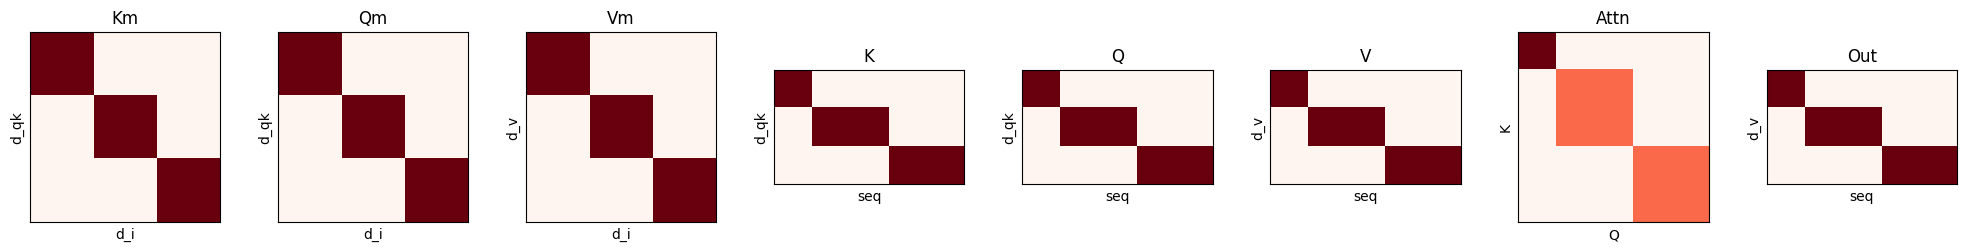

========================================    Learned    ========================================


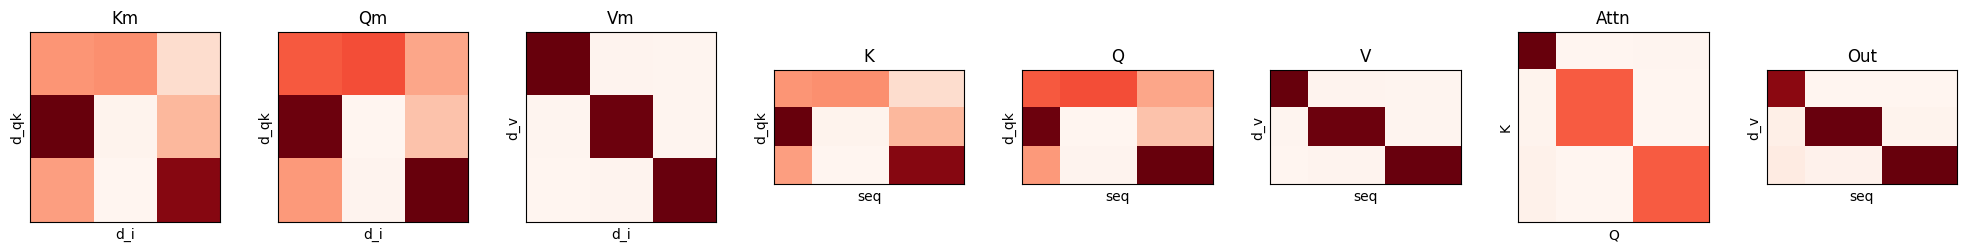

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]]),
 array([[9.07054924e-01, 3.71411799e-02, 5.58034481e-02],
        [1.77222980e-03, 9.76905289e-01, 2.13222332e-02],
        [1.77222980e-03, 9.76905289e-01, 2.13222332e-02],
        [8.03523652e-04, 1.59401374e-02, 9.83256416e-01],
        [8.03523652e-04, 1.59401374e-02, 9.83256416e-01]]))

In [12]:
# Compare the hand-designed and trained transformers
def make_batch_identity(tokens=tokens, max_len=7):
    seq, target = generate_test_cases_identity(tokens, max_len=max_len)
    return torch.FloatTensor(seq), torch.FloatTensor(target)

_set_seed(227)

A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])
transformer_py, loss = train_loop(make_batch_identity, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1])
seq = np.stack([A, B, B, C, C])
print("seq:", seq)
compare_transformers(np_transformer, transformer_py, seq)  # If the plots don't print correctly, re-run this cell

**Similarities:**:
1. Both include the same matrix $V$ as a diagonal matrix with the inputs values.
2. Both include for each row of the matrices Qm and Km a large value (corresponding to the value in $V$) and smaller val1ues for the rest
3. The attention matrix is the same between the two.

**Differences:**
1. The hand-designed matrices Qm and Km are diagonal and orthogonal to $X$, the ones learned by the transformer are more evenly distributed.

## Self-Attention: Attention by Position

In Transformers, tokens can decide what other tokens to attend to by looking at their positions. In this section, we'll explore how this works by **hand-designing a Transformer for the task of copying the first token of a sequence across the entire sequence.**

To accomplish this, we'll add a positional encoding to the input sequence. Transformers typically use a sinusoidal positional encoding or a learned positional encoding, but we'll **set the weight by hand to any value we choose**. These positional encodings will get concatenated to the input sequence inside the Transformer. For simplicity, we'll *concatenate* the positional encoding to the input embeddings instead of adding it.

Here are the example data points (where `A`, `B`, and `C` are vectors and `A:pos_0` represents the concatenation between vectors `A` and `pos_0`):

```
Input sequence --> Input sequence with positional encoding --> Output sequence
[A, B, C, C]   --> [A:pos_0, B:pos_1, C:pos_2, C:pos_3]    --> [A, A, A, A]
[C, A, C]      --> [C:pos_0, A:pos_1, C:pos_2]             --> [C, C, C]
[B, B, C]      --> [B:pos_0, B:pos_1, C:pos_2]             --> [B, B, B]
```

Once you've passed the test cases, run the training loop below to train the PyTorch model.

In [29]:
A = np.array([1,0,0])
B = np.array([0,1,0])
C = np.array([0,0,1])

tokens = [A, B, C]

pos = np.array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0,0, 0, 1]])

Qm = np.array([[0],
      [0],
      [0],
      [Huge_number],
      [Huge_number],
      [Huge_number],
      [Huge_number]])

Km = np.array([[-Huge_number],
      [-Huge_number],
      [-Huge_number],
      [Huge_number],
      [-Huge_number],
      [-Huge_number],
      [-Huge_number]])

Vm = np.array([[1, 0, 0],
      [0, 1, 0],
      [0, 0, 1],
      [0, 0, 0],
      [0, 0 ,0 ],
      [0, 0,0],
      [0, 0, 0]])


def generate_test_cases_first(tokens, max_len=5):
    seq_len = np.random.randint(1, max_len)
    input_arr = np.stack(random.choices(tokens, k=seq_len))
    # Expected output is to repeat the first row of the input k times
    expected_out = np.stack([input_arr[0]] * seq_len)
    return input_arr, expected_out

# Test your implementation
show_attention = False  # Set this to True for debugging
for i in range(10):
    seq, expected_out = generate_test_cases_first(tokens)
    np_transformer = NumpyTransformer(Km, Qm, Vm, pos=pos)
    out = np_transformer.forward(seq, verbose=show_attention)
    if not np.allclose(out, expected_out, rtol=1e-3):
        print(f'FAIL: {seq} -> {out} != {expected_out}')
    else:
        print('Good job!')

_set_seed(2017)
seq, _ = generate_test_cases_first(tokens)
np_transformer = NumpyTransformer(Km, Qm, Vm, pos=pos)
out = np_transformer.forward(seq, verbose=show_attention)
TO_SAVE["attention_by_position"] = out.reshape(-1).tolist()
TO_SAVE["attention_by_position_pos"] = pos.reshape(-1).tolist()
TO_SAVE["attention_by_position_Q"] = Qm.reshape(-1).tolist()
TO_SAVE["attention_by_position_K"] = Km.reshape(-1).tolist()
TO_SAVE["attention_by_position_V"] = Vm.reshape(-1).tolist()

Good job!
Good job!
Good job!
Good job!
Good job!
Good job!
Good job!
Good job!
Good job!
Good job!


Step 0: loss 1.4877721071243286
Step 1000: loss 0.00036026726593263447
Step 2000: loss 0.00014195351104717702
Step 3000: loss 4.8930869525065646e-05
Step 4000: loss 2.1190344341448508e-05
Step 5000: loss 0.0001353463449049741
Step 6000: loss 6.326211587293074e-05
Step 7000: loss 3.396003421585192e-06
Step 8000: loss 7.459262269549072e-05
Step 9000: loss 1.6956613762886263e-05
Step 10000: loss 9.286255954066291e-05
========================================  Hand Designed  ========================================


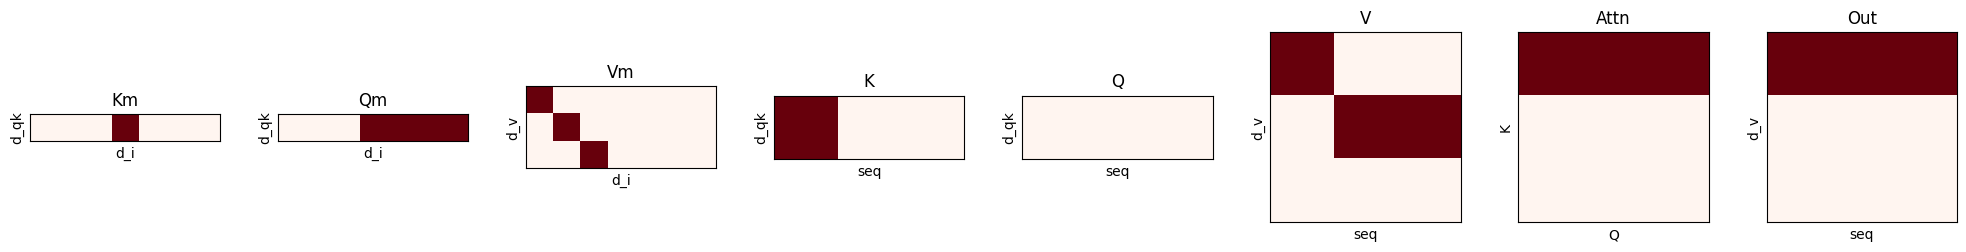

========================================    Learned    ========================================


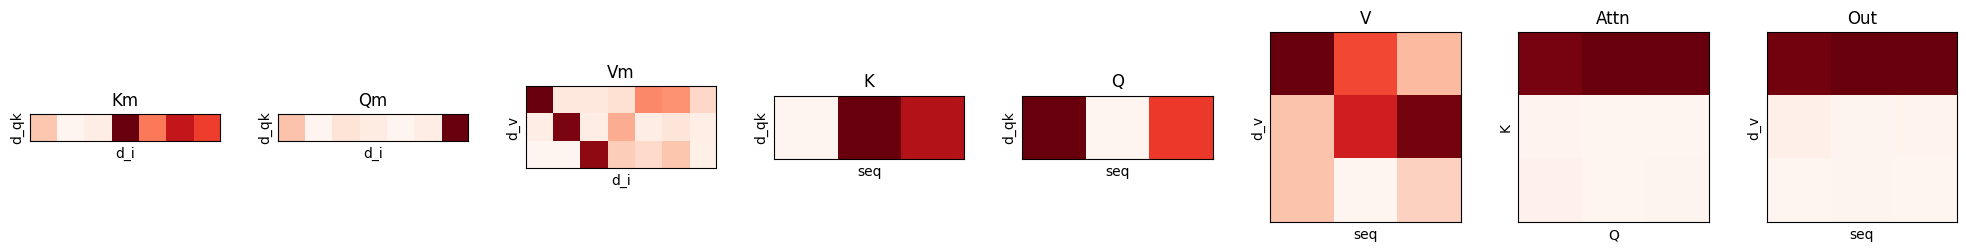

seq: [[1 0 0]
 [0 1 0]
 [0 1 0]]
Out (Hand designed) 
 [[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
 Out (Learned) 
 [[ 0.98  0.03 -0.01]
 [ 1.01 -0.   -0.  ]
 [ 1.    0.01 -0.  ]]


In [31]:
# Compare the numpy and trained pytorch transformers
def make_batch_first(tokens=tokens, max_len=5):
    seq, target = generate_test_cases_first(tokens, max_len=max_len)
    return torch.FloatTensor(seq), torch.FloatTensor(target)

pos_dim = pos.shape[1]
transformer_py, loss = train_loop(make_batch_first, input_dim=len(A), qk_dim=Km.shape[1], v_dim=Vm.shape[1], pos_dim=pos_dim, max_seq_len=pos.shape[0])
seq = np.stack([A, B, B])
out_np, out_py = compare_transformers(np_transformer, transformer_py, seq)
print("seq:", seq)
print(f'Out (Hand designed) \n {np.round(out_np, 2)}')
print(f' Out (Learned) \n {np.round(out_py, 2)}')